# Demo of VAE for anomaly detection of diverse sensor data
Trained on non-valve fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%matplotlib inline

In [2]:
from IPython.core.debugger import set_trace

In [3]:
from demo import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [5]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 6.514
Epoch: 95


In [6]:
params = model.demo()

Input size: torch.Size([1, 14, 512])
Encoded size: torch.Size([1, 1024, 4])
Latent size: torch.Size([1, 50, 1])
Decoded (output) size: torch.Size([1, 14, 512])


In [7]:
inp = params[0].cpu().detach().numpy()
out = params[-1].cpu().detach().numpy()
MSE = np.power((inp - out), 2).sum() / 2
print(f"MSE of random data = {MSE:.3f}")

MSE of random data = 24244.617


Next we need to load the datasets of sensors readings.

In [8]:
data_path = Path('data/hydraulic')
train_dl, val_dl, test_dl = load_datasets(data_path)

Let's get some random samples from the dataset for examples and generate new versions.

In [9]:
data, targets = get_random_samples(test_dl)

In [10]:
list_target_classes(test_dl)

0 = fail
1 = norm


In [11]:
targets = targets.cpu().numpy()
targets

array([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [12]:
criterion = VAE1DLoss()
criterion = criterion.to(device)

In [13]:
model.eval()
with torch.no_grad():
    # Generate
    data = data.to(device)
    gen_data, mu, logvar = model(data)
    loss, loss_desc = criterion(gen_data, data, mu, logvar, reduce=False)
    

In [14]:
gen_err = -loss_desc['logp']
gen_err

tensor([25632.3477, 13185.3320, 15831.4922, 11624.6777, 13188.4863, 23171.6035,
        11521.0732, 11625.7676, 23654.4570, 26720.3359, 23029.5078, 11490.3789,
        11873.1475, 24614.8008, 11696.6436, 15337.5391, 11572.7051, 11538.6348,
        11599.9883, 11587.8867], device='cuda:0')

[[ 0.9131269   0.8576076   0.9604009   0.8004174   0.45051304]
 [ 1.3850762   3.304089    3.2990987   3.895125    3.6891372 ]
 [-0.6023792  -1.2124841  -0.6604583  -0.32398325 -0.45431936]
 [ 0.9493342   0.6758028   0.271143   -0.07460529 -0.58695346]
 [ 0.20960969  1.7032473   2.4338222   2.6832004   2.4815884 ]]
MSE = 25632.349609375


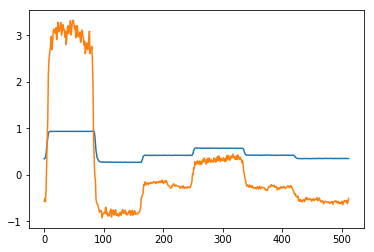

In [15]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

[[ 1.4317857   1.7945122   1.3107152   1.2180091   1.0120856 ]
 [ 1.550879    3.880094    3.505278    3.7198505   3.0361907 ]
 [ 1.0898262   1.4383142   1.2817454   1.0500238   0.9152473 ]
 [ 1.0976077   1.0352571   0.59754974  0.20091924 -0.23588413]
 [ 0.46498588  2.8780384   2.9476354   3.213171    3.6637459 ]]
MSE = 13185.3330078125


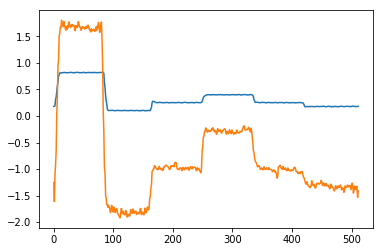

In [16]:
idx = 1
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

In [19]:
err = np.zeros(targets.shape)
for i, target in enumerate(targets):
    err[i] = -loss_desc['logp'][i]
    print(f"Target = {target}, MSE = {err[i]:.3f}")

Target = 0, MSE = 25632.348
Target = 0, MSE = 13185.332
Target = 1, MSE = 15831.492
Target = 0, MSE = 11624.678
Target = 1, MSE = 13188.486
Target = 1, MSE = 23171.604
Target = 1, MSE = 11521.073
Target = 1, MSE = 11625.768
Target = 0, MSE = 23654.457
Target = 0, MSE = 26720.336
Target = 0, MSE = 23029.508
Target = 1, MSE = 11490.379
Target = 0, MSE = 11873.147
Target = 1, MSE = 24614.801
Target = 0, MSE = 11696.644
Target = 0, MSE = 15337.539
Target = 0, MSE = 11572.705
Target = 0, MSE = 11538.635
Target = 0, MSE = 11599.988
Target = 0, MSE = 11587.887


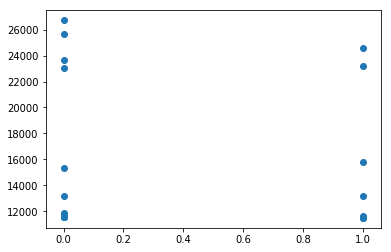

In [20]:
plt.scatter(targets, err)

Show the data plots.

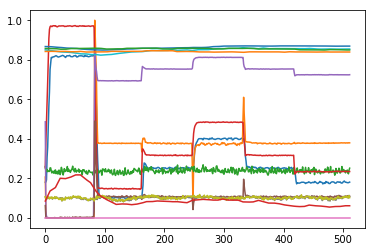

In [21]:
show_plot(sample)

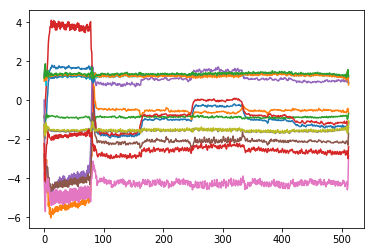

In [22]:
show_plot(gen_sample)

Let's score the success of the recreation and look for outliers.

In [ ]:
def compute_scores(X, model, criterion):
    assert X.shape[0] == 1, "Must compute score for one sample at a time"
    X_hat, mu, logvar = model(X)
    loss, loss_desc = criterion(X_hat, X, mu, logvar, reduce=False)
    score = {'loss': loss.item(),
             'KL': loss_desc['KL'].item(),
             'error': -loss_desc['logp'].item()}
    return score

def score(dl):
    score_names = ['loss', 'KL', 'error']
    classes = dl.dataset.classes
    scores = {(name, cls): [] for name in score_names for cls in classes}
    
    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(tqdm(dl)):
            X = X.to(device)
            for j in range(X.shape[0]):
                data = X[j, :].unsqueeze(0)
                cls = classes[y[j].item()]
                score = compute_scores(data, model, criterion)
                for name in score_names:
                    scores[(name, cls)].append(score[name])
    return scores

In [ ]:
scores = score(test_dl)

In [ ]:
test_means = pd.DataFrame()
for (name, cls), item in scores.items():
    test_means.loc[name, cls] = np.array(item).mean()

print("###################### TEST MEANS #####################")
print(test_means)

In [ ]:
val_means = pd.DataFrame()
for (name, cls), item in score(val_dl).items():
    val_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(val_means)

In [ ]:
train_means = pd.DataFrame()
for (name, cls), item in score(train_dl).items():
    train_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(train_means)

In [ ]:
val_dl.dataset.classes